<!DOCTYPE html>
<html>
<head>
<meta charset="UTF-8">
</head>
<body>
    
    
<div style="font-family:Georgia" align="center">
<h1 align="center">Quantum mechanics - Computation activities</h1>
<h1 align="center"><span style="text-decoration: gray underline overline" > Wave packet propagation</span></h1>
    
<br>
<br>
<br>
    
<h3> By: </h3>
<h3> Maxime Legrand </h3>
<h3> Chiari Even </h3>
    
<br>
<br>
<br>
    
<h3> Supervisor :</h3>
<h3> David Viennot </h3>
    
<br>
<br>
<br>

<h4> $ 3^{th} $ january 2023 <h4> 

    
    
</div>
</body> 
</html>

<h1 style="font-family:Georgia;text-decoration:gray underline">Introduction</h1>




The main objective of this last practical work is to study the propagation of a wave packet in three different configurations:

- In a box

- In front of a potential barrier

- Quantum Fermi accelerator 


In order to do so, one needs to mix up the most accurate methods seen in the two first practical works.
In the first one, we have integrated the Schrodinger's equation with two methods over time, the most accurate was the split operator one. For the second one, we have constructed the Hamiltonian for 3 different systems and propagated it over space, the most accurate was the Hamiltonian constructed in the DVR/FBR basis.

Here we will propagate a wave packet through the space and the time for the three previous mentioned cases with a variant of split operator mixing the integration of the Schrodinger's equation and the evolution of the Hamiltonian. We'll draw the particle position probability before enlightening and discussing the various effects in stake for each considered system.

<h1 style="font-family:Georgia;text-decoration:gray underline">Requirements and limits</h1>

This program was made under Python 3.8.10 and may not work properly with previous versions. Also please consider having the following libraries installed :

- Numpy
- Scipy
- Matplotlib


In [1]:
import numpy as np
from numpy import linalg as LA
from scipy import linalg as LA2
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mp3d

# Figure size (inches)
plt.rcParams['figure.figsize'] = 9,6

# Figure dpi (px)
plt.rcParams['figure.dpi'] = 150

<h1 style="font-family:Georgia;text-decoration:gray underline">Variant of the split operator integrator</h1>

In order to have an efficient integrator, we'll use the properties of $H_{k}$ and $V$ which are diagonal in the FBR basis and in the DVR one respectively. As not all the systems are time dependent, we'll also have to consider two computations for $H$, whose dependency relies on the one of $V$.

The different quantities below are expressed with our program variable names.

<h1 style="font-family:Georgia;text-decoration:gray underline">Kinetic Hamiltonian construction</h1>

As previously seen, the kinetic Hamiltonian $H_{k}$ has an analytic expression in the DVR basis:

\begin{equation}
    \big[ H_{K,DVR} \big]_{ij} = \frac{\hbar^{2}}{2m}
     \begin{cases}
      \frac{\pi^{2}((N_{step}+1)^{2}+2)}{3x_{max}^{2}}\\
      \frac{(-1)^{j-i}2\pi^{2}}{x_{max}^{2}sin^{2}((j-i)\pi/(N_{step}+1)}
    \end{cases}
\end{equation}

<h2 style="font-family:Georgia;text-decoration:gray">Time-independent case</h2>

If $V$ has no dependency on time, implying that neither has $H$, one can propagate the wave function $\Psi(t)$ over time as follows :

\begin{equation}
    \Psi(t+1) = e^{H} \Psi(t)
\end{equation}

With :

\begin{equation}
    e^{H} = e^{-i\hbar^{-1}(H_{K}+V_{diag})\Delta t}
\end{equation}

<h2 style="font-family:Georgia;text-decoration:gray">Time-dependent case</h2>

The case for which $V$ is time dependent implies that we have to split the Hamiltonian $H(t_{n})$ exponential in exponential of its terms to apply the split operator on $V(t_{n})$ only. By using the <i>Baker-Campbell-Hausdorff formula</i>, one can express the exponential of terms such as :
<br>
<br>
<center>$\begin{equation}
    e^{-i\hbar^{-1}(H_{k}+V(t_{n}))\Delta t_{n}} = e^{-i\hbar^{-1}V(t_{n})\frac{\Delta t}{2}} e^{-i\hbar^{-1}H_{k}\Delta t} e^{-i\hbar^{-1}V(t_{n})\frac{\Delta t}{2}}
\end{equation}$</center>
    
Which can finally be seen again as $e^{-i\hbar^{-1}H(t_{n})\Delta t}$. One can thus compute the positions associated to a given time $t_{n}+1$ following the equation in the previous part provided knowing the value of $\Psi(t_{n})$. In our case, we'll give a set of initial conditions $\Psi(0)$ to $\Psi(t)$ and simply propagate it from these initial values.

<h1 style="font-family:Georgia;text-decoration:gray underline">Construction of the different used objects </h1>
<h2 style="font-family:Georgia;text-decoration:gray"> Parameters </h2>

Here is the list of adjustable parameters used for this practical work :


In [2]:
# Toggle the potential 
# 1: wave packet in a box
# 2: in front of a potential barrier
# 3: Quantum Fermi accelerator
POT=1

# Space discretization
X_MAX=10
N_STEP=100
DELTA_X=X_MAX/N_STEP

# Space axis
XD=[i*DELTA_X for i in range(N_STEP)]

# Time discretization
T_MAX=16
N_TIME=300
DELTA_T=T_MAX/N_TIME

# Time axis
XT=[i*DELTA_T for i in range(N_TIME)]

# Particle mass
M=1

# Initial wave number
K0=0.05*np.sqrt(6)

# STD of gaussian packet
SIGMA_X=0.5

# Potential period
TAU=0.5

# Wave packet period
p=2


<h2 style="font-family:Georgia;text-decoration:gray"> Wave function </h2>

We need a function which computes the wave function values at time $t = 0$ (initial conditions) in order to be integrated with its values over time once propagated for the three different systems:

In [3]:
def Psi(POT):
    """Returns the wave function array with its initial conditions
       filled (first column).

    Args:
        POT (int): input system

    Returns:
        2D (array, complex): Psi, initial values of the wave function with
        respect to the selected system.
    """
    
    PSI=np.zeros((N_STEP,N_TIME),dtype="complex")

    # Box
    if POT == 1 :
        # Exponential prefactor
        C=1/np.sqrt(SIGMA_X*np.sqrt(2*np.pi)) 
        
        for i in range(N_STEP):
            PSI[i,0]=C*np.exp(-(XD[i]-X_MAX/2)**2/(4*SIGMA_X**2))
            
    # Barrier
    elif POT == 2:
        # Exponential prefactor
        C=1/np.sqrt(SIGMA_X*np.sqrt(2*np.pi)) 
        
        for i in range(N_STEP):
            PSI[i,0]=C*np.exp(-(XD[i]-10/2)**2/(4*SIGMA_X**2))*np.exp(1j*K0*XD[i])
    
    # Quantum Fermi accelerator
    elif POT == 3:
        # Exponential prefactor
        C=np.sqrt(2/X_MAX)
        
        for i in range(N_STEP):
            PSI[i,0]=C*np.sin(p*np.pi*XD[i]/X_MAX)

    else:
        return 'Please choose a valid system (1-3)'
            
    return PSI


<h2 style="font-family:Georgia;text-decoration:gray"> Potential </h2>

The potential is different for each case, so we had to build a function to get its value in space and in time for any system :

In [4]:
def V(x,POT,t=0):
    """Potential value in an evaluated point

    Args:
        x (float): space coordinate
        POT (int): selected system
        t (float, optional): Time dependency. Defaults to 0.

    Returns:
        float: Potential at given space and time point if time dependent
    """
    
    # Box
    if POT == 1:
        return 0
    
    # Barrier
    elif POT == 2:
        x0=10
        x1=11
        if x0 < x < x1:
            v=3
        else:
            v=0
        
        return v

    # Fermi accelerator
    elif POT == 3:
        X_MIN = 0.75  *X_MAX
        w = 2 * np.pi / TAU
        born = X_MAX - ((X_MAX-X_MIN) / 2) * (1 - np.cos(w*t))
        
        if x < born :
            return 0
        
        else:
            return 10**15


This function evaluates the potential for a grid point $(x,t)$ for each case. Time $t$ is an optional parameter because in the first two systems the potential is time-independent, so we set it to $ t = 0 $.

<h2 style="font-family:Georgia;text-decoration:gray"> Hamiltonian construction (in DVR basis)
 </h2>

The construction of the Hamiltonian is the same for systems one and two but isn't for the third, so we need to build a function returning the proper Hamiltonian for each case :

In [5]:
def Hamiltonian(V,POT):
    """Function building the selected system hamiltonian

    Args:
        V (float): Potential value in an evaluated point
        POT (int): Selected system
    Returns:
        2D array: System hamiltonian
    """
    
    HK=np.zeros((N_STEP,N_STEP),dtype="complex")

    # Looping over space steps twice
    for i in range(N_STEP):
        
        for j in range(N_STEP):
            
            if i == j :
                HK[i,j]=np.pi**2*((N_STEP+1)**2+2)/(3*X_MAX**2*2*M)
                
            else:
                HK[i,j]=(-1)**(j-i)*2*np.pi**2/(X_MAX**2*np.sin((j-i)*np.pi/(N_STEP+1))**2*2*M)

    # Checking if system is time-dependant
    if POT == 3:
        return HK
    
    # If time independant
    else:
        # Diagonal potential matrix
        Vmat=np.diag([V(XD[j],POT) for j in range(N_STEP)])
        
        # Hamiltonian
        H=HK +Vmat
        return H


$V$ is the potential function and $POT$ is a parameter which indicates which system is studied.
For the third system we return $H_{K}$ the kinetic part of the Hamiltonian because we need to propagate the potential part in time. For the time-independent case we can directly compute the Hamiltonian $H$ by the sum of $H_{K} + Vmat$ with $Vmat$ the diagonal potential.

<h2 style="font-family:Georgia;text-decoration:gray"> Propagator </h2>


Finally we need to propagate the wave function and the Hamiltonian :

In [6]:
#normalisation function form TP1
def Norm(vector):
    return(np.sqrt(np.dot(np.conjugate(vector),vector)))


def Propagator(Psi,H,POT,V):
    """Propagates H with respect to its time
    dependency

    Args:
        Psi (2D array): Wave function matrix to be computed
        H (2D array): System Hamiltonian
        POT (int): Selected system
        V (float): Potential value in an evaluated point

    Returns:
        2D array: Space and time computed wave function
    """
    norm = np.zeros(N_TIME,dtype = 'complex_')
    expH=LA2.expm(-1j*H*DELTA_T)
    
    # Looping over time steps
    for i in range(N_TIME-1):

        # Checking time dependency
        if POT == 3:
            expV=np.diag([np.exp(-1j*V(XD[j],POT,XT[i])*DELTA_T/2) for j in range(N_STEP)])
            expH=expV @ expH @ expV
            Psi[:,i+1]=np.dot(expH,Psi[:,i])
            
        else:
            Psi[:,i+1]=np.dot(expH,Psi[:,i])
            
        #normalisation for time 0 until time N_TIME-1
        Psi[:,i] = Psi[:,i]/Norm(Psi[:,i])
        
    # normalisation for the last value
    Psi[:,-1] = Psi[:,-1]/Norm(Psi[:,-1])
    
    #take the modulus squared of our wave function
    return np.real((Psi* np.conjugate(Psi))) 


Psi is the initial condition ($t=0$), $H$ the Hamiltonian, $POT$ the parameter to indicate the system and $V$ the potential function.
This function is built similarly to the Hamiltonian one: we check the time dependency and we compute the algorithm explained in the theoretical part for each of the 3 cases to integrate the wave function for each time step.

<h1 style="font-family:Georgia;text-decoration:gray underline"> Wave packet in a box and quantum carpet </h1>


Let's study the propagation of a wave packet in a box using the previously defined parameters. This wave packet can be seen as:


\begin{equation}
\Psi(x,t=0) = \frac{1}{\sqrt{\sigma_x \sqrt{2 \pi}}} e^{-\frac{{(x-x_{max}/2)}^2}{4\sigma_x^2}}
\end{equation}

We propagate the wave packet after having constructed the system Hamiltonian and we plot the result :

average probability in the box =  0.9999999999999962


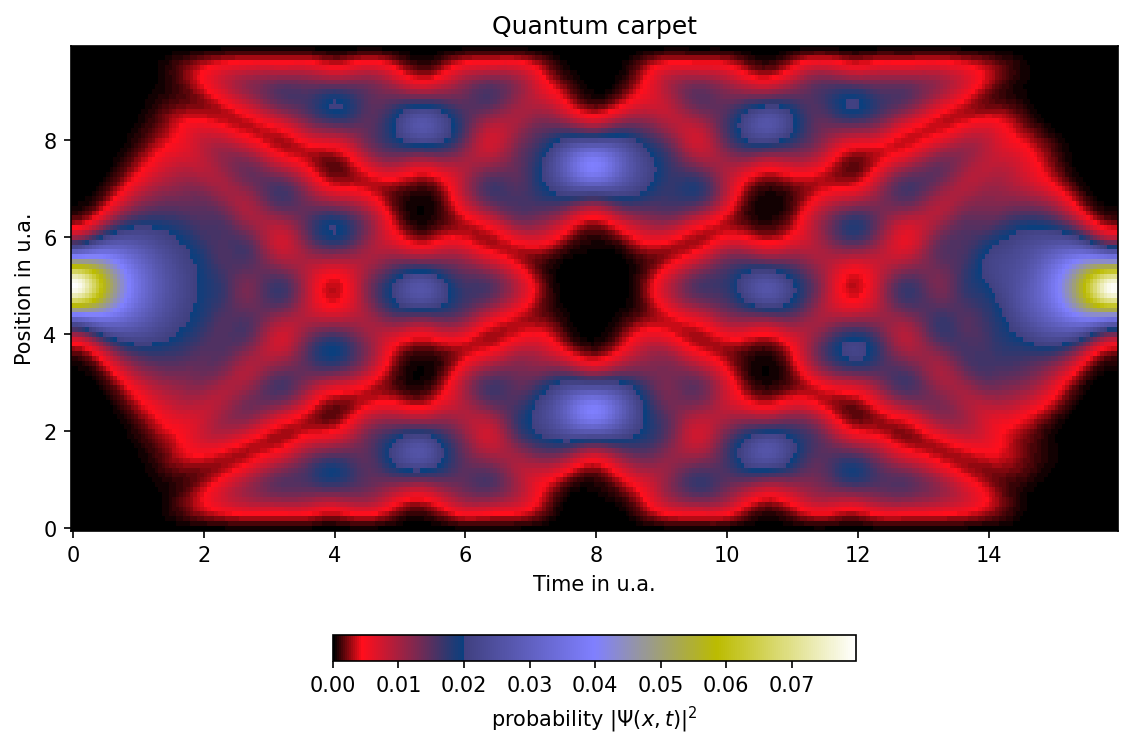

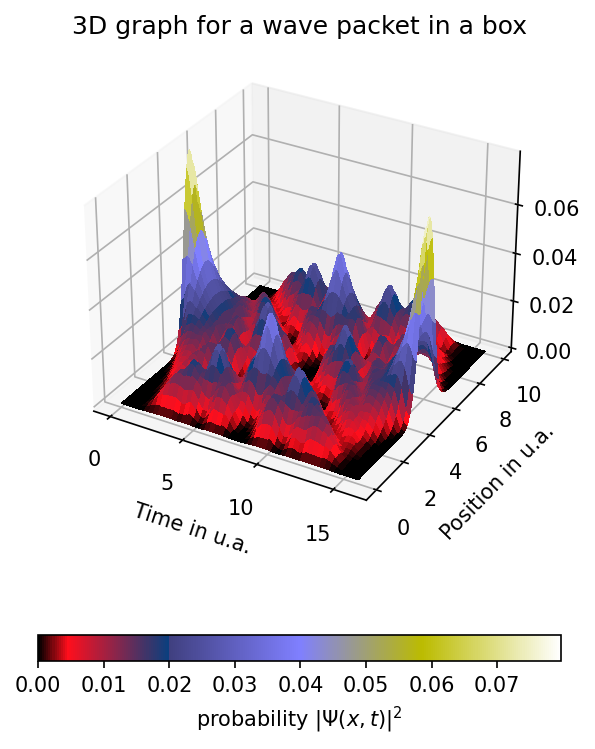

In [7]:
# initial condition
PSI=Psi(POT)

# construct the hamiltonian system
H=Hamiltonian(V,POT)

# propagate the system
P=Propagator(PSI,H,POT,V)

# check the total probability of the system to be sure its close to one 
print("average probability in the box = ",sum(sum(P)/N_TIME))

# make the colors graph
plt.pcolormesh(XT, XD, P, cmap="gist_stern", shading='auto', vmin=0, vmax=np.max(P))
plt.colorbar(label=r'probability $|\Psi (x,t)|^{2}$', orientation='horizontal', shrink=0.5)
plt.xlabel("Time in u.a.")
plt.ylabel("Position in u.a.")
plt.title("Quantum carpet")
plt.show()

# make the 3D graph
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(XT, XD)
surf = ax.plot_surface(X, Y, P, cmap="gist_stern", linewidth=0, antialiased=False, vmin=0, vmax=np.max(P))


# Add a color bar which maps values to colors and label
fig.colorbar(surf, label=r'probability $|\Psi (x,t)|^{2}$', orientation='horizontal', shrink=0.5)
plt.title("3D graph for a wave packet in a box")
ax.set_xlabel("Time in u.a.")
ax.set_ylabel("Position in u.a.")
plt.show()


<h2 style="font-family:Georgia;text-decoration:gray"> Interpretation </h2>

We can see the wave packet evolves with time, the dark area means almost or zero chance to find the particle in this area and the colors area means respectively to the color bar the chance to find the particle, this pattern is called Quantum Carpet.

<h3 style="font-family:Georgia;text-decoration:gray"> Dispersion phenomenon </h3>

The dispersion phenomenon can be explained with the definition of a Gaussian's wave packet, it contains waves of different momenta and hence different velocities, so the waves with a bigger momenta travel faster than others because they have a higher velocity. The dispersion is clearly visible before time $t=2 \ u.a.$, the wave packet spreads out in the box.

This can be understood with the uncertainty principle $\sigma_x \sigma_p = \hbar/2$ at the beginning the wave packet is well localized in terms of position and after the wave packet starts to spread in the box so the uncertainty on the position increases with the time until $t = 16 u.a.$ where the uncertainty on the position seems to be returned to the initial condition.

The reason why the packet is not spreading uniformly in the box and form this pattern is because of the box edges which are infinite potential walls at $x = 0 \ u.a.$ and $x = 20 \ u.a.$, so when the fastest plane wave of the wave packet meet theses wall and get reflected on it, this changes its direction. When the reflected fastest wave meet the slowest, the Gaussian's wave packet interfers with itself. Thus, we observe destructive interferences in the dark area and constructive ones in the colored area.

<h3 style="font-family:Georgia;text-decoration:gray">Rest in classical dynamics and stationnary regime in quantum mechanics comparison</h3>

We know the notion of rest in classical mechanics, meaning that a body in rest remains in its state until a perturbation changes his speed or his direction. This is the lowest possible kinetic energy state. In quantum physics, the stationary state is the lowest possible energy state but this is not a rest state because the wave function is not stationary itself (we have still a probabilistic behavior on position).

To sum this up, this difference comes from the fact that if we measure a classic particle at a fixed time $t$, its position $x$ is well determined whereas for the case of a quantum one, if we fix a time $t$, its position $x$ is not well determined.

There is always be a phase factor which is time-dependent but for an isolated system it can remain the same with delay in time.

On our graph, if we increase $t_{max}$ we can see several times where the probability distribution shape looks like the initial condition, and this is what is called quantum revival.

<h3 style="font-family:Georgia;text-decoration:gray"> Wave-packet revival </h3>

One could tell that the phenomenon of wave-packet revival (ie. the same probability distribution shape repeated over time) is in opposition with the 2nd principle of thermodynamics. Indeed, this principle tells us that the entropy of an isolated system cannot decrease. If we naively apply this principle to our probability distribution, one can notice that it is spread out at $t = 2 u.a.$ (maximum entropy), and then comes back to its initial shape at $t = 16 u.a.$ (minimum entropy).

However, this explanation is only valid if we speak about a physical transformation of the system, but here we speak about a probability which cannot be interpreted as a physical transformation, just as the potential wall isn't physical. The particle can interact with the potential wall (be reflected or transmitted) but it doesn't loose of gain of energy while doing it, the particle always keep the same energy in our case.

<h1 style="font-family:Georgia;text-decoration:gray underline" >Wave packet in front of a potential barrier </h1>

<h2 style="font-family:Georgia;text-decoration:gray"> Parameters :</h2>


In [8]:
# Toggle the potential 
# 1: wave packet in a box
# 2: in front of a potential barrier
# 3: Quantum Fermi accelerator
POT=2

# Space discretization
X_MAX=20
N_STEP=100
DELTA_X=X_MAX/N_STEP

# Space axis
XD=[i*DELTA_X for i in range(N_STEP)]

# Time discretization
T_MAX=4
N_TIME=100
DELTA_T=T_MAX/N_TIME

# Time axis
XT=[i*DELTA_T for i in range(N_TIME)]

# Initial wave number
K0=0.5*np.sqrt(6)


Here we will study the behavior of a wave-packet in front of a potential barrier, which will intuitively illustrate the tunnel effect at some point. We consider a particle of mass $m = 1 a.u.$ belonging to $[0, x_{max}]$ with $x_{max} = 20 u.a.$ and set up a potential barrier $V(x)$ from $x_{0} = 10 a.u.$ to $x_{1} = 11 a.u.$ such as :
<br>
<br>
<center>$\begin{equation}
    V(x) = 
    \begin{cases}
        V_{0} \text{ if } x \in [x_{0},x_{1}]\\
        0 \text{ otherwise}
    \end{cases}
\end{equation}$</center>

The wave-packet describing the particle is a Gaussian wave-packet with standard deviation $\sigma_{x} = 0.5a.u.$ centered at $\frac{x_{0}}{2} = 5a.u.$ with initial momentum $k_{0}>0$ :

<center>$\begin{equation}
\Psi(x,t=0) = \frac{1}{\sqrt{\sigma_x \sqrt{2 \pi}}} e^{-\frac{{(x-x_{0}/2)}^2}{4\sigma_x^2}} e^{ik_{0}x}
\end{equation}$</center>

We introduce the quantity $\hbar k_{E} = \sqrt{2mV_{0}} = \sqrt{6} a.u.$. This momentum can be interpreted in a classical way such as it is the critical value above which the particle will entirely get through the wall, and below which it will be entirely reflected. We'll study the influence of the potential barrier on our system by plotting the density colors graphs and the 3D graphs for random parameters :

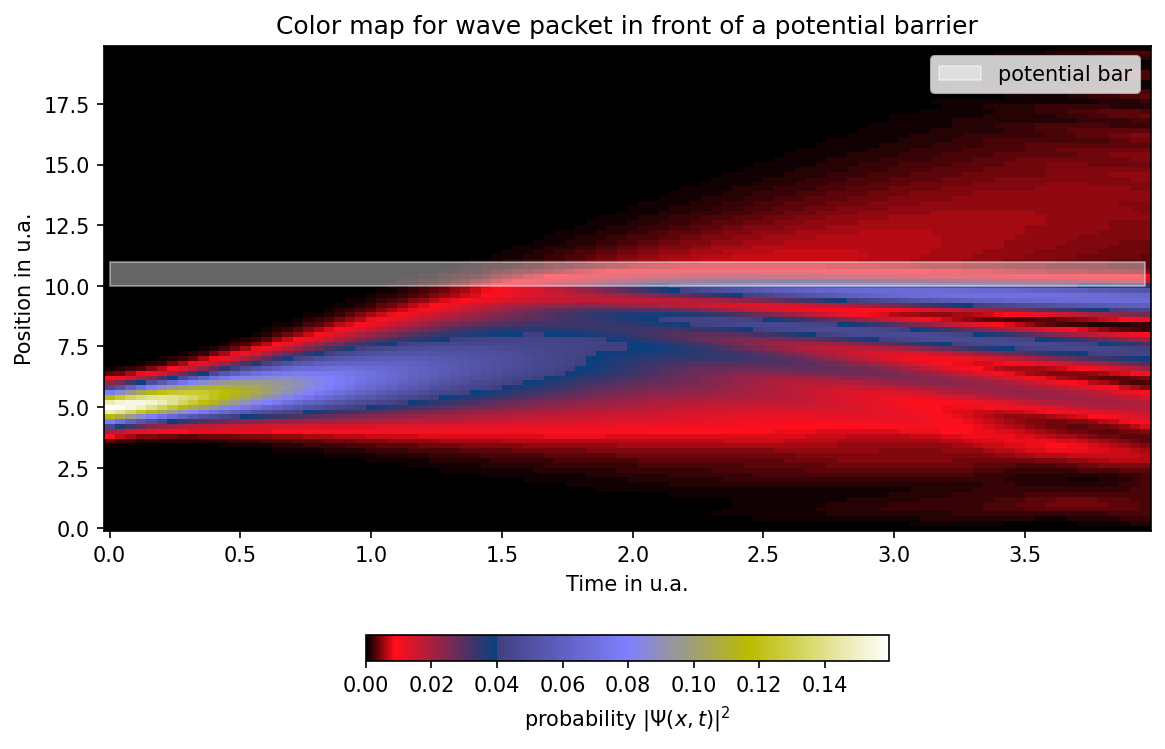

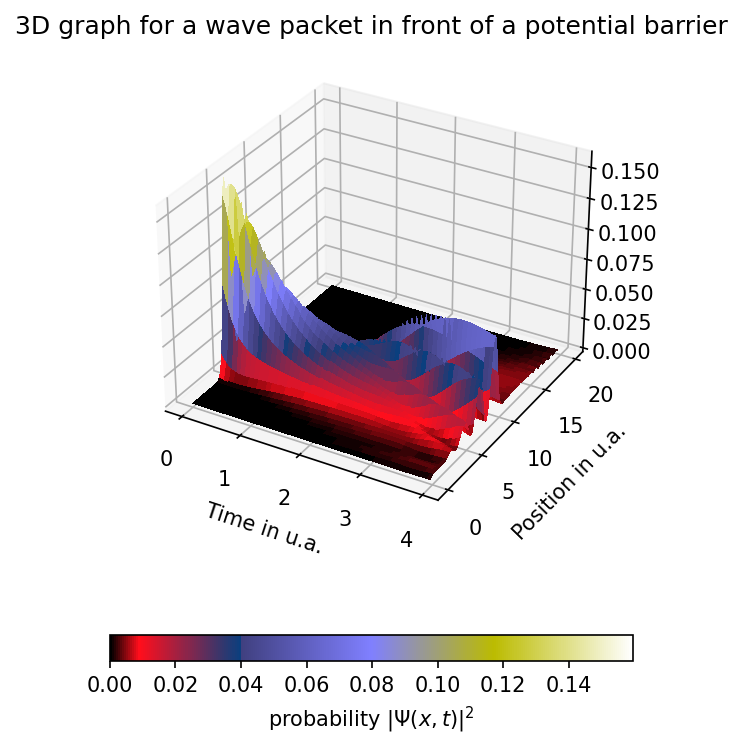

In [9]:
#initial condition
PSI=Psi(POT)

#construction of the system hamiltonian
H=Hamiltonian(V,POT)

#Propagate the system
P=Propagator(PSI,H,POT,V)

# make the colors graphs
plt.pcolormesh(XT ,XD ,P , cmap="gist_stern", shading='auto', vmin=0, vmax=np.max(P))
plt.colorbar(label=r'probability $|\Psi (x,t)|^{2}$', orientation='horizontal', shrink=0.5)
plt.fill_between(XT, [10]*N_TIME, [11]*N_TIME, alpha=0.4, color="white", label='potential bar')
plt.xlabel("Time in u.a.")
plt.ylabel("Position in u.a.")
plt.title("Color map for wave packet in front of a potential barrier")
plt.legend()
plt.show()

# make the 3D graph
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(XT, XD)
surf = ax.plot_surface(X, Y, P, cmap="gist_stern", linewidth=0, antialiased=False, vmin=0, vmax=np.max(P))

# Add a color bar which maps values to colors and label
fig.colorbar(surf, label=r'probability $|\Psi (x,t)|^{2}$', orientation='horizontal', shrink=0.5)
ax.set_xlabel("Time in u.a.")
ax.set_ylabel("Position in u.a.")
plt.title("3D graph for a wave packet in front of a potential barrier")
plt.show()


For $k = 0.5 k_{E}$, the particle has a small chance to pass trough the barrier and most of it is reflected on it. In a classical case we would've expected a full reflection, this difference is a good way to visualize the differences between the classical world and the quantum one.

Let's now study that for different values of $k_0$ to see clearlier the influence of this parameter.
In order to save space and time we'll plot all values of $k_{0}$ in a $n$ x $n$ subplot (default 3 x 3) so we will have $n^2$ different values uniformly distributed between $0.05 k_{E}$ and $2 k_{E}$.
One can adjust the maximum value of $k_{0}$ by changing $k_{0 , max}$ (in our case $k_{0 , max} = 2 $ ) and the number of subplots by changing $n$, the number of rows and columns of the subplot. We will also plot a transparent potential barrier to see clearly where and when the wave packet and the barrier are meeting.

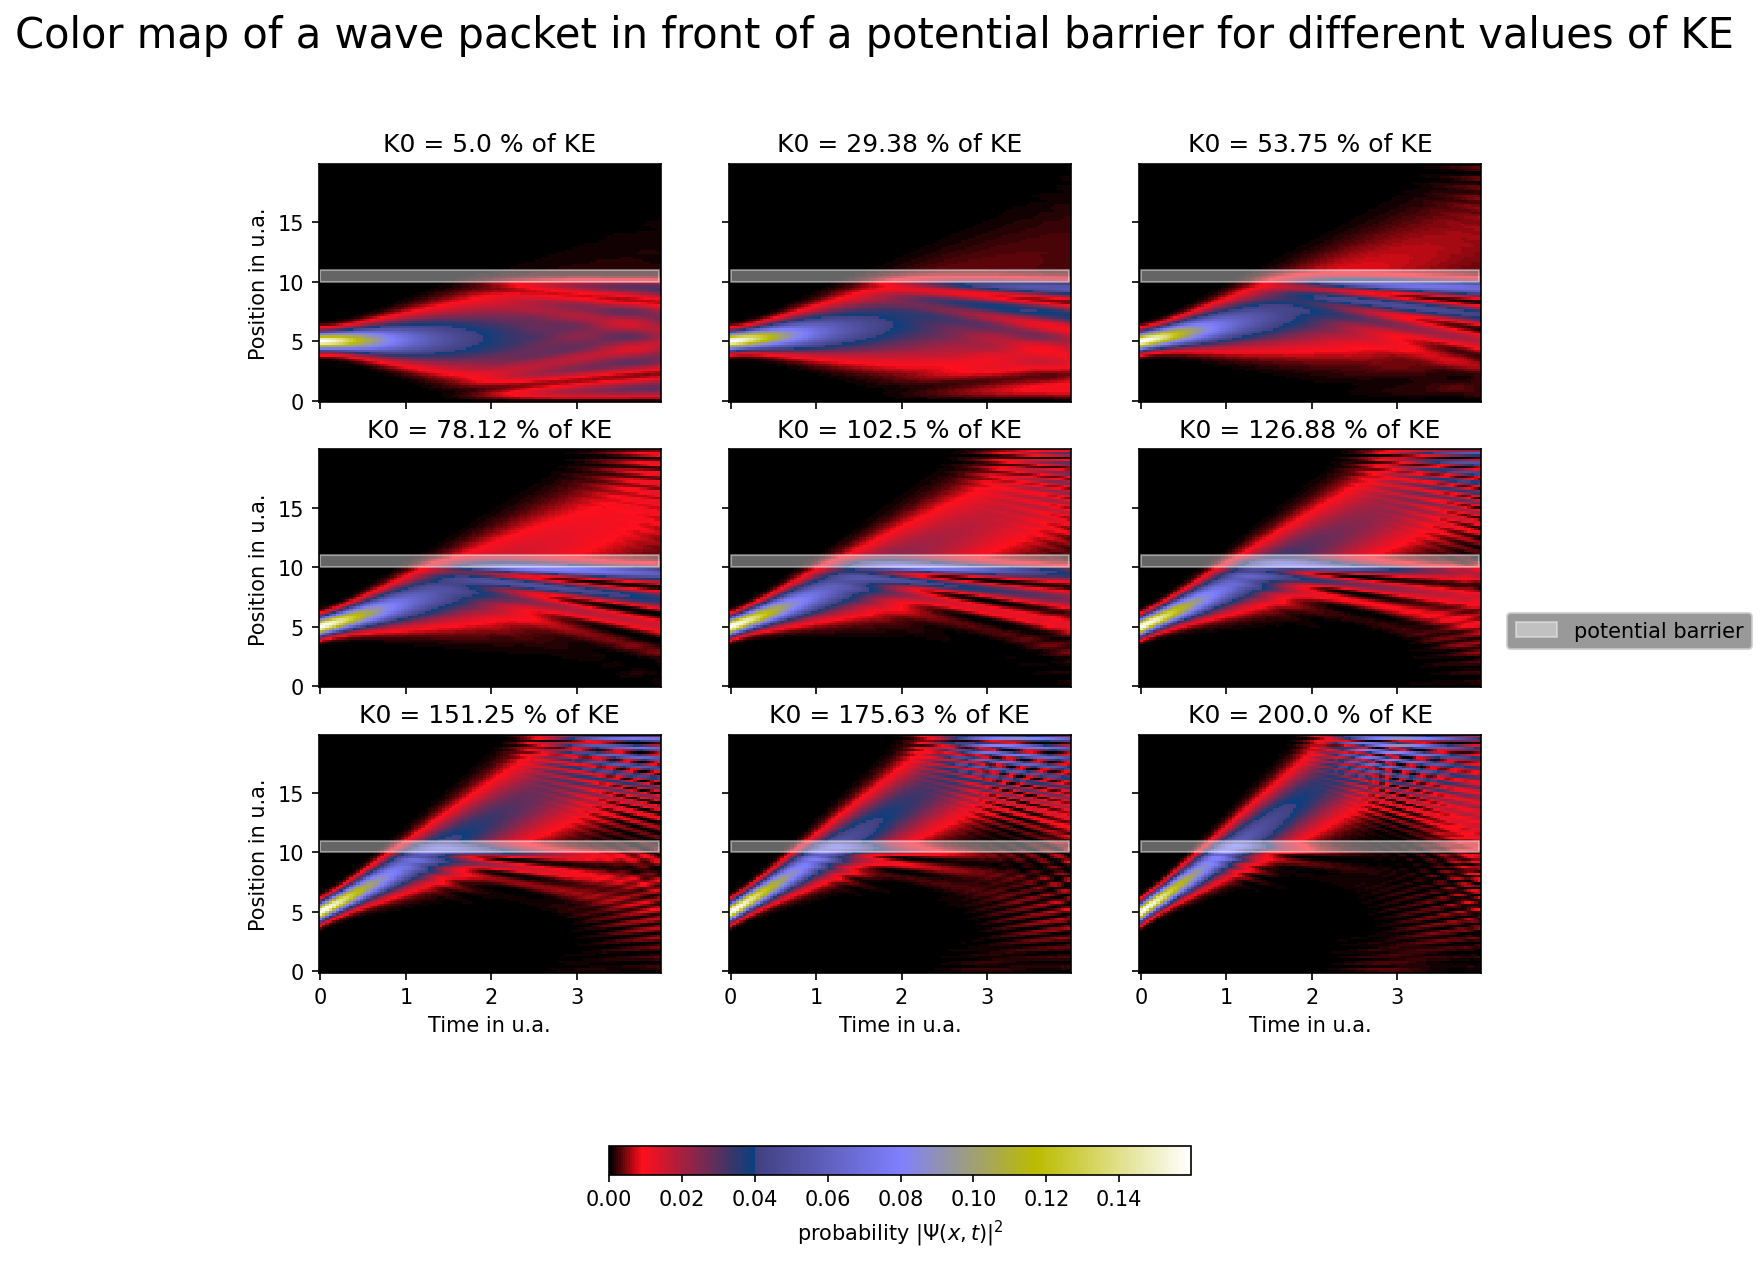

In [10]:
# Make the graph bigger
plt.rcParams['figure.figsize'] = 10,10

# Number of lines and rows
n =3

# Values max in amount of KE
K0_MAX=2

# Values of K0
list_K0=[np.sqrt(2*M*3)*i for i in np.linspace(0.05,K0_MAX,n**2)]

# Incrementation parameter
int=0

# Make the subplot
fig, axs = plt.subplots(n, n)

# Do a loop to chnage the system for each subplot
for ax in axs.flat:
    
    #value of K0
    K0 = list_K0[int]

    # Initial condition
    PSI=Psi(POT)

    # Construct the hamiltonian
    H=Hamiltonian(V,POT)

    # Propagate our system
    P=Propagator(PSI,H,POT,V)

    # Make the density colors graph
    im=ax.pcolormesh(XT,XD,P,cmap="gist_stern",shading='auto', vmin=0, vmax=np.max(P))
    ax.set(xlabel="Time in u.a.", ylabel="Position in u.a.")
    ax.set_title(f"K0 = {round(K0/np.sqrt(6)*100,2)} % of KE")

    # increment the parameter
    int +=1

    # Plot the potential barrier for each subplot
    if ax == axs[-1,-1]:
        ax.fill_between(XT,[10]*N_TIME, [11]*N_TIME, alpha=0.4,color="white",label='potential barrier')
    else:
        # Plot the label for the last graph because its the same for each subplot
        ax.fill_between(XT,[10]*N_TIME, [11]*N_TIME, alpha=0.4, color="white")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()  


# Label and colors bar
plt.suptitle("Color map of a wave packet in front of a potential barrier for different values of KE ", fontsize="20")
fig.legend(loc="center right", prop={"size" : 10}, facecolor = "gray")    
fig.colorbar(im, ax=axs.ravel().tolist(), label=r'probability $|\Psi (x,t)|^{2}$', location="bottom", shrink=0.5)
plt.show()


One can clearly distinguish cases confirming the meaning of $k_{E}$. Indeed, for the cases in which $k_{0} < k_{E}$, the particle probability is almost all reflected on the wall. However, we can distinguish that a small probability is propagated through the potential wall, which illustrates the phenomenon of tunnel effect. For the case $k_{0} > k_{E}$, we notice the opposite behavior. The particle tends to get through the potential wall, whereas a small probability of reflection remains.

By considering once again the influence of $k$ in the wave-packet propagation, one can see that the higher $k_{0}$ is, the faster the wave-packet will collide with the potential wall.

For weak probabilities of reflection on the potential barrier (ie. $k > k_{E}$), one cannot properly distinguish interferences due to the color map, therefore it seems like they're emerging from nowhere.

<h1 style="font-family:Georgia;text-decoration:gray underline"> Quantum Fermi accelerator :</h1>

In [11]:
# Toggle the potential 
# 3: Quantum Fermi accelerator
POT=3

# Space discretization
X_MAX=20
N_STEP=100
DELTA_X=X_MAX/N_STEP

# Space axis
XD=[i*DELTA_X for i in range(N_STEP)]

# Time discretization
T_MAX=30
N_TIME=400
DELTA_T=T_MAX/N_TIME

# Time axis
XT=[i*DELTA_T for i in range(N_TIME)]

# Particle mass
M=1

# STD of Gaussian packet
SIGMA_X=0.5

# Potential period
TAU=24

# Wave packet period
p=2

# Resize figure
plt.rcParams['figure.figsize'] = 5,5


The last studied system is a Quantum Fermi accelerator, which is described by a box $x_{max} =20$ with a potential barrier with time-dependent width at the right of the box :
<br>
<br>
<center>$\begin{equation}
V(x, t)= \begin{cases}0 & \text { if } x<x_{\max }-\frac{\left(x_{\max }-x_{\min }\right)}{2}(1-\cos (\omega t)) \\ V_0 & \text { if } x \geq x_{\max }-\frac{\left(x_{\max }-x_{\min }\right)}{2}(1-\cos (\omega t))\end{cases}
\end{equation}$</center>
<br>
<br>
with: 

- $V_0 =10^{15}$ u.a.
<br>
<br>
- $\omega = \frac{2 \pi}{\tau}$ u.a.
<br>
<br>
- $\tau \in [0.5;30]$ u.a.



The propagated wave function is the following:
<br>
<br>
<center>$\begin{equation}
\psi(x, t=0)=\sqrt{\frac{2}{x_{\max }}} \sin \left(\frac{p \pi x}{x_{\max }}\right)
\end{equation}$</center>

with: $p \in \mathbf{N^{*}} $

Instead of the previous system we have a wave function not a wave packet so we expect a non-spreading behavior. Moreover, the wave function sinusoidal term is scaled with the length of the box, which means the box is a half-period of our sinusoidal term. 

The parameter $p$ rules the period of the sinus, meaning that the higher $p$ is, the more tails our wave-function will have.

We will plot a transparent potential barrier on subplots to clearly see its position over time and its influence on our system for each parameter values. Let's first plot a 2D density color and a 3D graph for parameters $p=2$ and $\tau = 24$ u.a.:

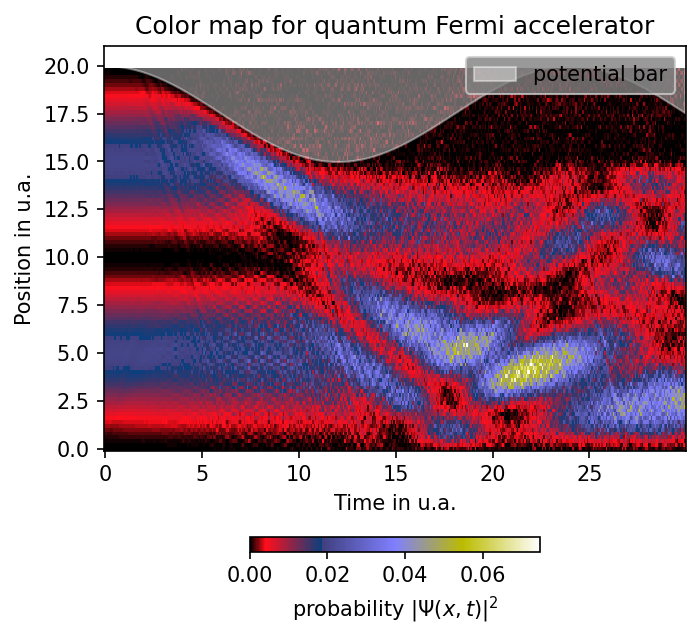

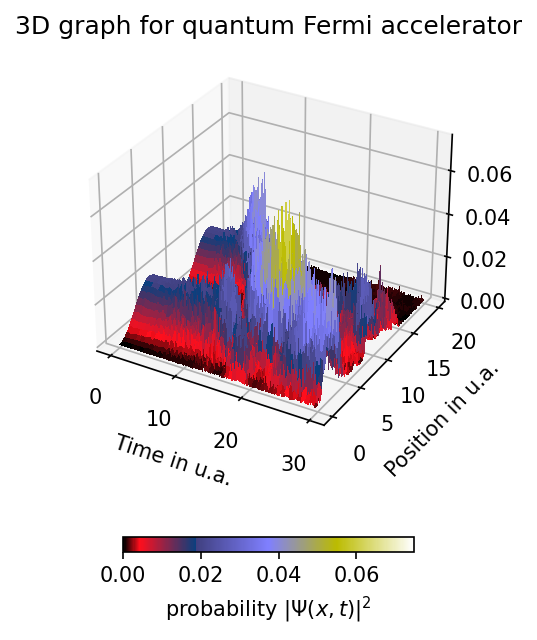

In [12]:
#initial condition
PSI=Psi(POT)

#construct the hamiltonian system
H=Hamiltonian(V,POT)

#Propagate the system
P=Propagator(PSI,H,POT,V)

#Make the potential function
potential=[X_MAX-((X_MAX-0.75*X_MAX)/2)*(1-float(np.cos((2*np.pi/TAU*i)))) for i in XT]

# make the colors graph
plt.pcolormesh(XT,XD,P,cmap="gist_stern",shading='auto', vmin=0, vmax=np.max(P))
plt.colorbar(label=r'probability $|\Psi (x,t)|^{2}$',orientation='horizontal',shrink=0.5)
plt.fill_between(XT, potential,y2=[20]*N_TIME, alpha=0.4,color="white",label='potential bar')
plt.xlabel("Time in u.a.")
plt.ylabel("Position in u.a.")
plt.title("Color map for quantum Fermi accelerator")
plt.legend(facecolor = "gray",prop={"size" : 10})
plt.show()

# make the 3D graph
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(XT, XD)
surf = ax.plot_surface(X, Y, P, cmap="gist_stern", linewidth=0, antialiased=False, vmin=0, vmax=np.max(P))

# Add a color bar which maps values to colors and label
fig.colorbar(surf,label=r'probability $|\Psi (x,t)|^{2}$',orientation='horizontal',shrink=0.5)
ax.set_xlabel("Time in u.a.")
ax.set_ylabel("Position in u.a.")
plt.title("3D graph for quantum Fermi accelerator")
plt.show()


We can indeed see that our wave function has non-spreading behavior. The wave function is like avoiding the potential bar, which makes sense but the behavior of our wave function is very complicated to interpret so we will discuss about it in a second time.

On the 3D graph, we can clearly see the amplitude of our wave-function is distributed with respect to $p$ before encountering the potentiel barrier. Once it hits the barrier, probabilities seem to group and thus increase.

Just as for the second system, we will plot different subplots to clearly see the behavior of our system with specified parameters $p$ and $\tau $ for each subplot. We scaled $p$ from 1 to 3 and $\tau $ u.a. from 0.5 to 30 u.a. 

Plots are composed by $n$ x $m$ subplots not to have too small graphs, if you want to see more value of tau you can increase $m$.

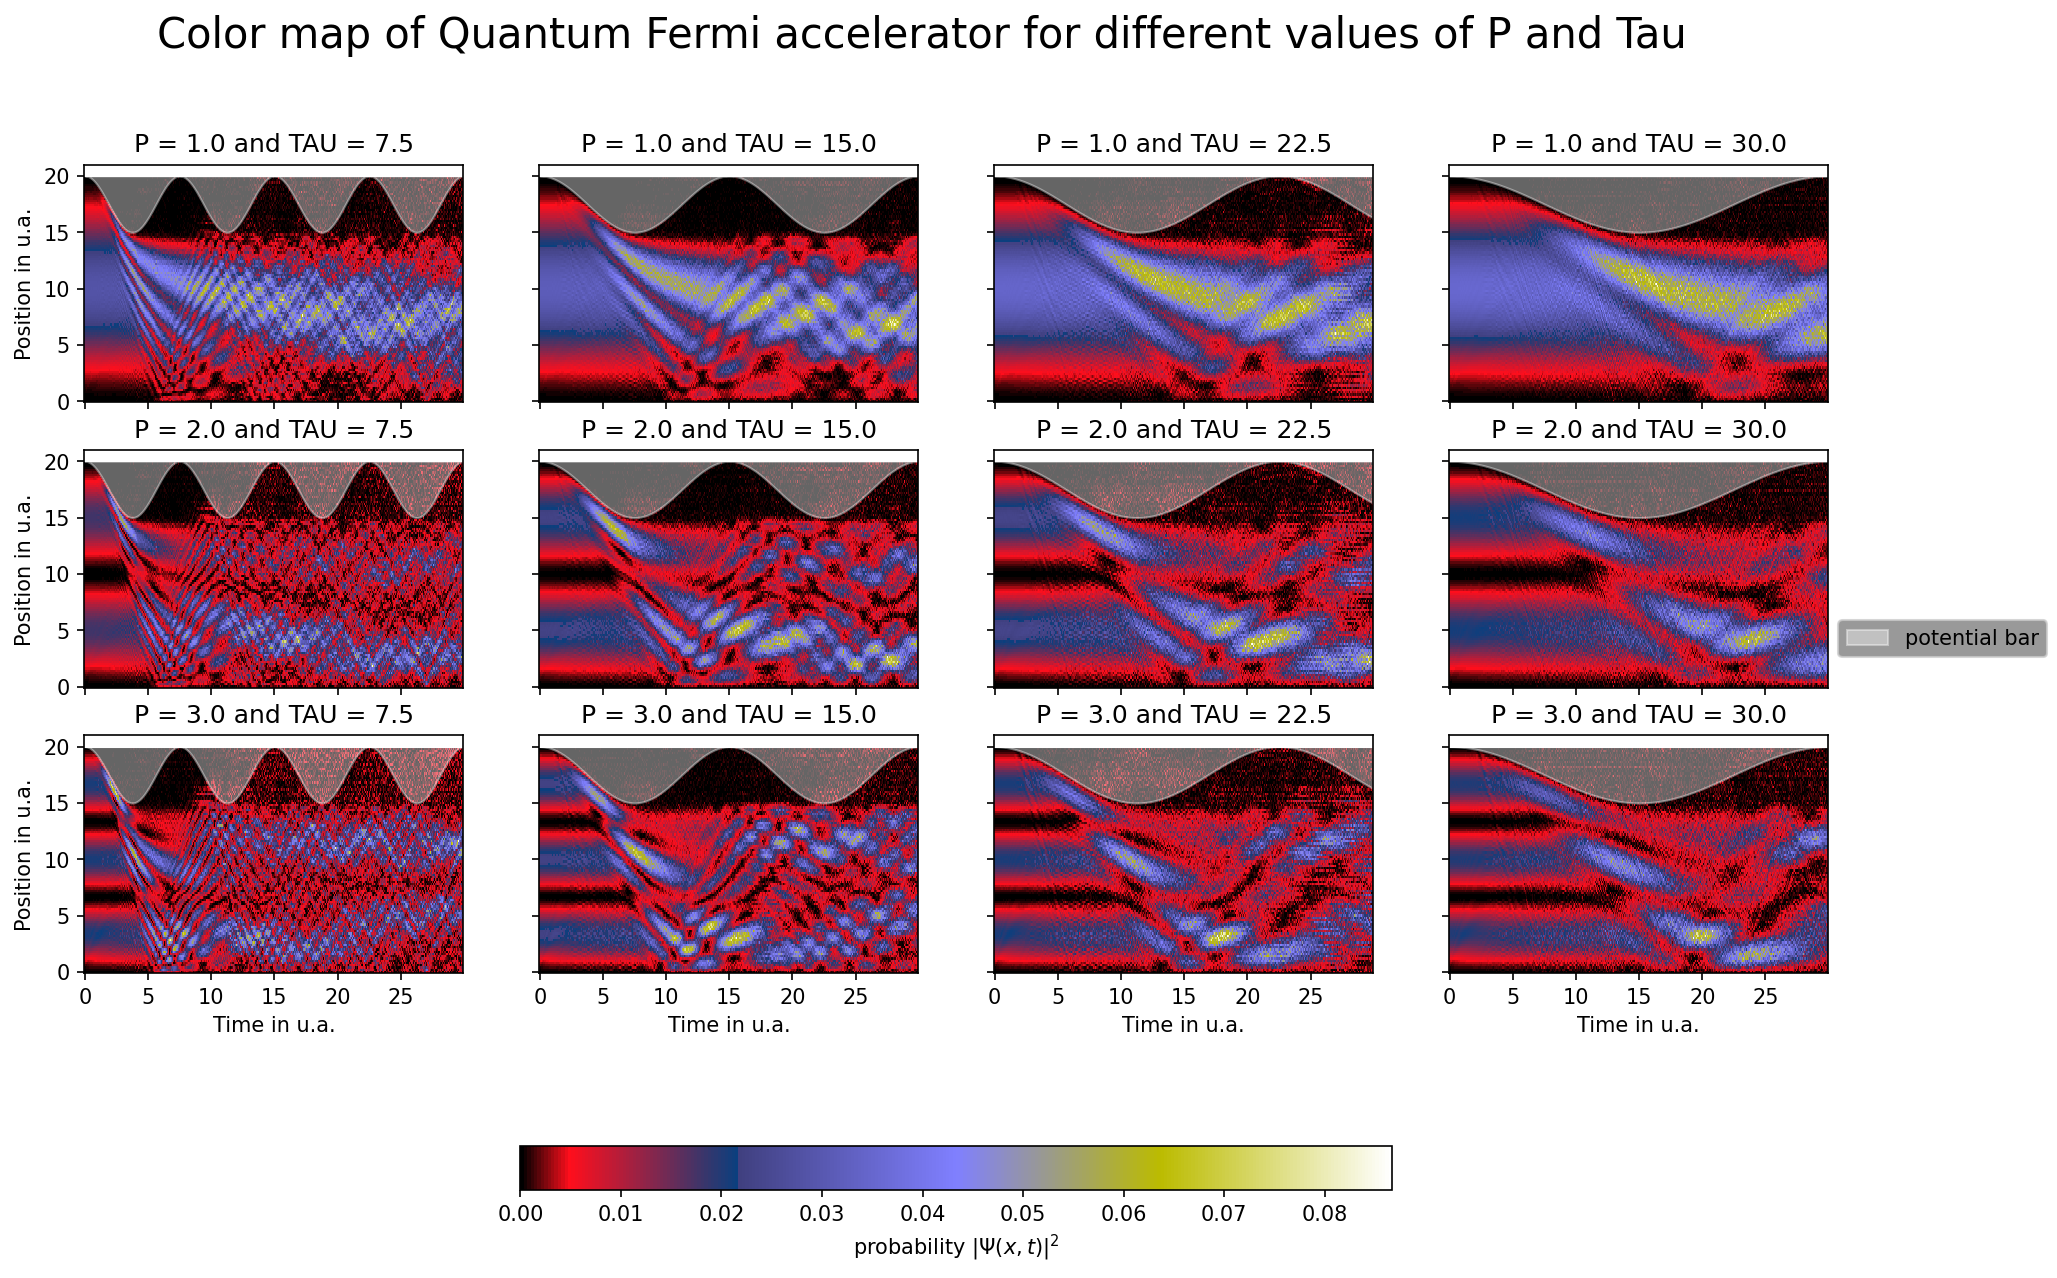

In [13]:
# Make the graph bigger
plt.rcParams['figure.figsize'] = 15, 10


# Number of lines and rows
n, m = 3, 4


# Make the subplot
fig, axs = plt.subplots(n, m)

# Do a loop to chnage the system for each subplot
for ax in axs.flat:

    # Value of p
    p=float(np.where(axs == ax)[0] +1)

    # Value of tau
    TAU=float((np.where(axs == ax)[1] +1)*30/m)
    
    # Draw the potential function
    potential=[X_MAX - ((X_MAX - 0.75 * X_MAX) / 2) * (1- float(np.cos((2 * np.pi / TAU *i )))) for i in XT]

    # Initial condition
    PSI=Psi(POT)

    # Construct the hamiltonian
    H=Hamiltonian(V, POT)

    # Propagate our system
    P=Propagator(PSI, H, POT, V)

    # Make the density colors graph
    im=ax.pcolormesh(XT, XD, P, cmap = "gist_stern", shading = 'auto', vmin = 0, vmax = np.max(P))
    ax.set(xlabel = "Time in u.a.", ylabel = "Position in u.a.")
    ax.set_title(f"P = {p} and TAU = {TAU}")

    # Plot the potential barrier for each subplot
    if ax == axs[-1,-1]:
        ax.fill_between(XT, potential, np.max(potential), alpha = 0.4, color = "white", label = 'potential bar')
    else:
        # Plot the label for the last graph because its the same for each subplot
        ax.fill_between(XT, potential, np.max(potential), alpha = 0.4, color = "white")
    

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Label and colors bar
plt.suptitle("Color map of Quantum Fermi accelerator for different values of P and Tau ", fontsize = "20")   
fig.legend(loc = "center right", prop = {"size" : 10}, facecolor = "gray")    
fig.colorbar(im, ax=axs.ravel().tolist(), label = r'probability $|\Psi (x,t)|^{2}$', location = "bottom", shrink = 0.5)
plt.show()


On this graph we have $ 3 x 4 $ subplot, respectively corresponding to the values of $p$, and to the values of $\tau$. We can clearly see the shape of the barrier changing with the values of $\tau$, the lowest $\tau$ is, the faster the barrier will oscillate between its minimum and its maximum width. The influence of the $p$ parameter is as we expected for $p=3$, we have three "probability beams".

For $p=1$ we can see the meeting between $\psi$ and the potential bar because of the deformation of $\psi$, when it's deforming we have self-interference which causes a reduced probability to find the particle or an increased probability to find it. In this case we can see that $\psi$ keeps an approximate global shape with interferences but we don't loose all the information of our probability especially for the big values of $\tau$. Indedd, $\psi$ is just like compressed a little bit and this causes the probability to be increased in the middle of the rest of the box.

For $p=2$ we can see for small $\tau$ that interferences occur and we loose a consequent amount of information our system. For high values of $\tau$, the two "beams" are pushed to the other side of the box. One thus sees like interferences between the two "beams" causing an increasing probability to find the particle in the yellow area. 
For $p=3$ we can see that for small values of $\tau$, we loose almost all the information on $\psi$ and we witness the chaos in the rest of the box, for high values of $\tau$, we have a more stable system with our three "beams" like crunching in the rest of the box and a spike of higher probability to find the particle but compared to the two previous cases, we loose more information on it. 

In the potential barrier at certain moment we still have some red points which normally indicate that the probability to find the particle is not negligible but we think this is a "bug" of accuracy of our simulation because the potential barrier is very high and when we increase the number of points ($ N_{TIME}$ and $N_{STEP}$), we reduce the number of red points but we can't increase enough the accuracy on our graph to remove all the red points.

<h1 style="font-family:Georgia;text-decoration:gray underline"> Conclusion</h1>

In this practical work we have seen three interesting systems by propagating the wave function with or without time-dependent potentials :

- the first system was the propagation of a wave packet in a box, we have seen the so called Quantum Carpet, this result enlighted the nature of the wave packet by demonstrating self-interference of $\psi$. It was due to the fact the wave packet is an infinite sum of plane waves with different momenta and this is why we could observe a dispersion phenomenon with the wave packet and not with the wave function (3rd system). We have seen the quantum packet revival which reflects an important difference between stationary waves in quantum physics and rest in classical mechanics.

- The second system has reinforced what we showed and concluded in the first one by showing the intrinsic nature of quantum physics, which is an undeterministic theory.
With this potential barrier we have seen even if the moment is not enough high we see the particle has still a probability to pass trough it by tunnel effect and reciprocaly even with a higher momentum the particle still have a probability to reflect on the potential barrier.

- The last system showed how a particle behaves with a fluctuating potential barrier. Indeed, this potential barrier accelerates the probability distribution cycle (patterns getting smaller) of the particle while reducing the space in which it can be found, and this is why it is called a quantum Fermi accelerator. The higher $\tau$ is, the less the distribution is accelerated.

With these three systems and the two previous practical works, we have seen several methods to numerically integrate the Schrödinger's equation, how to represent infinite dimensional systems, and here we combined the two first best methods to build up the so called variant of split operator. We thus propagated a particle in a box and studied the behavior of $\psi$ in presence of a potential barrier or not and what we can do after studying the influence of these objects.